# Demo - Generating Groundtruth from S2 images and FloodMaps

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))

import logging
import json
from src.data.create_gt import (
    generate_water_cloud_binary_gt,
    generate_land_water_cloud_gt,
)
import pandas as pd
import numpy as np
from rasterio import features
import rasterio
import geopandas as gpd
import os
from shapely.ops import cascaded_union
from src.data.utils import filter_pols, filter_land
from typing import Optional, Dict, Tuple
from src.data.utils import GCPPath

from google.cloud import storage
import json
import rasterio.windows


from rasterio.plot import show as rasterio_plot
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [6]:
# 1 - Demo images (str), floodmaps+S2 Image

# 1.1 - Demo Image
demo_s2_image = GCPPath("gs://ml4floods/worldfloods/public/test/S2/EMSR333_01RATTALORO_DEL_MONIT01_v1_observed_event_a.tif")

# 1.2  - Demo Load the stuffs
with rasterio.open(demo_s2_image.full_path, "r") as s2_image:
    print(s2_image)
    print(s2_image.meta)

<open DatasetReader name='gs://ml4floods/worldfloods/public/test/S2/EMSR333_01RATTALORO_DEL_MONIT01_v1_observed_event_a.tif' mode='r'>
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1376, 'height': 793, 'count': 13, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, 12.49080453109671,
       0.0, -8.983152841195215e-05, 37.927769610810316)}


In this cell, we want to run the previous inputs through the GT script. 

We are generating the original ground truth

In [7]:
# 1.3 - Demo Floodmap
demo_floodmap = GCPPath("gs://ml4cc_data_lake/0_DEV/2_Mart/worldfloods_v1_1/test/floodmap/EMSR333_01RATTALORO_DEL_MONIT01_v1_observed_event_a.shp")

# 1.4 - Load Floodmap with Geopandas
floodmap_gdf = gpd.read_file(demo_floodmap.full_path, )

### Original Ground Truth

In [12]:
%%time

# Run it through the GT script
gt, gt_meta = generate_land_water_cloud_gt(
    demo_s2_image.full_path, demo_floodmap.full_path, keep_streams=True,
)
# Pray

CPU times: user 59.2 s, sys: 107 ms, total: 59.3 s
Wall time: 20.4 s


#### Demo Image

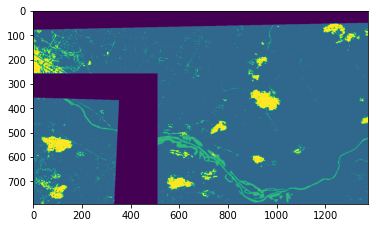

In [13]:
fig, ax = plt.subplots()

rasterio_plot(gt, vmin=0, vmax=3)

plt.show()

In this cell, we want to run the previous inputs through the GT script. 

We are generating the new ground truth.

In [15]:
from src.data.utils import load_json_from_bucket

demo_floodmap_meta = GCPPath("gs://ml4cc_data_lake/0_DEV/2_Mart/worldfloods_v1_1/test/meta/EMSR333_01RATTALORO_DEL_MONIT01_v1_observed_event_a.json")

floodmap_meta = load_json_from_bucket(demo_floodmap_meta.bucket_id, demo_floodmap_meta.get_file_path())

# storage_client = storage.Client()
# bucket = storage_client.get_bucket("ml4floods")
# blob = bucket.blob(demo_floodmap_meta)

# # Download the contents of the blob as a string and then parse it using json.loads() method
# floodmap_meta = json.loads(blob.download_as_string(client=None))
floodmap_meta

{'source': 'CopernicusEMS',
 'satellite': 'Sentinel-1',
 'satellite date': '2018-11-03T17:03:57Z',
 'shape': [793, 1376],
 'pixels invalid S2': 213171,
 'pixels clouds S2': 25221,
 'pixels water S2': 16551,
 'pixels land S2': 836225,
 'pixels flood water S2': 9829,
 'pixels hydro water S2': 6660,
 'pixels permanent water S2': 62,
 'method clouds': 's2cloudless',
 'bounds': [12.49080453109671,
  37.85653320877964,
  12.614412714191557,
  37.927769610810316],
 's2metadata': [{'date_string': '2018-11-04 09:52',
   'system:time_start': 1541325153150,
   'area_rel': 99}]}

In [33]:
%%time

# Run it through the GT script
gt_binary, gt_meta_binary = generate_water_cloud_binary_gt(
    demo_s2_image.full_path, demo_floodmap.full_path, floodmap_meta, keep_streams=True,
)

cloud_channel, water_channel = 0, 1

CPU times: user 1min 3s, sys: 132 ms, total: 1min 3s
Wall time: 21.4 s


In [34]:
gt_meta_binary

{'gtversion': 'v2',
 'encoding_values': [{0: 'invalid', 1: 'clear', 2: 'cloud'},
  {0: 'invalid', 1: 'land', 2: 'water'}],
 'shape': [793, 1376],
 's2tiff': 'EMSR333_01RATTALORO_DEL_MONIT01_v1_observed_event_a.tif',
 'permanent_water_tiff': 'None',
 'cloudprob_tiff': 'None',
 'method clouds': 's2cloudless',
 'pixels invalid S2': 0,
 'pixels clouds S2': 48570,
 'pixels water S2': 23394,
 'pixels land S2': 1067774,
 'pixels flood water S2': 14923,
 'pixels hydro water S2': 8471,
 'pixels permanent water S2': 0,
 'bounds': BoundingBox(left=12.49080453109671, bottom=37.85653320877964, right=12.614412714191557, top=37.927769610810316),
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, 12.49080453109671,
        0.0, -8.983152841195215e-05, 37.927769610810316)}

#### Demo Image

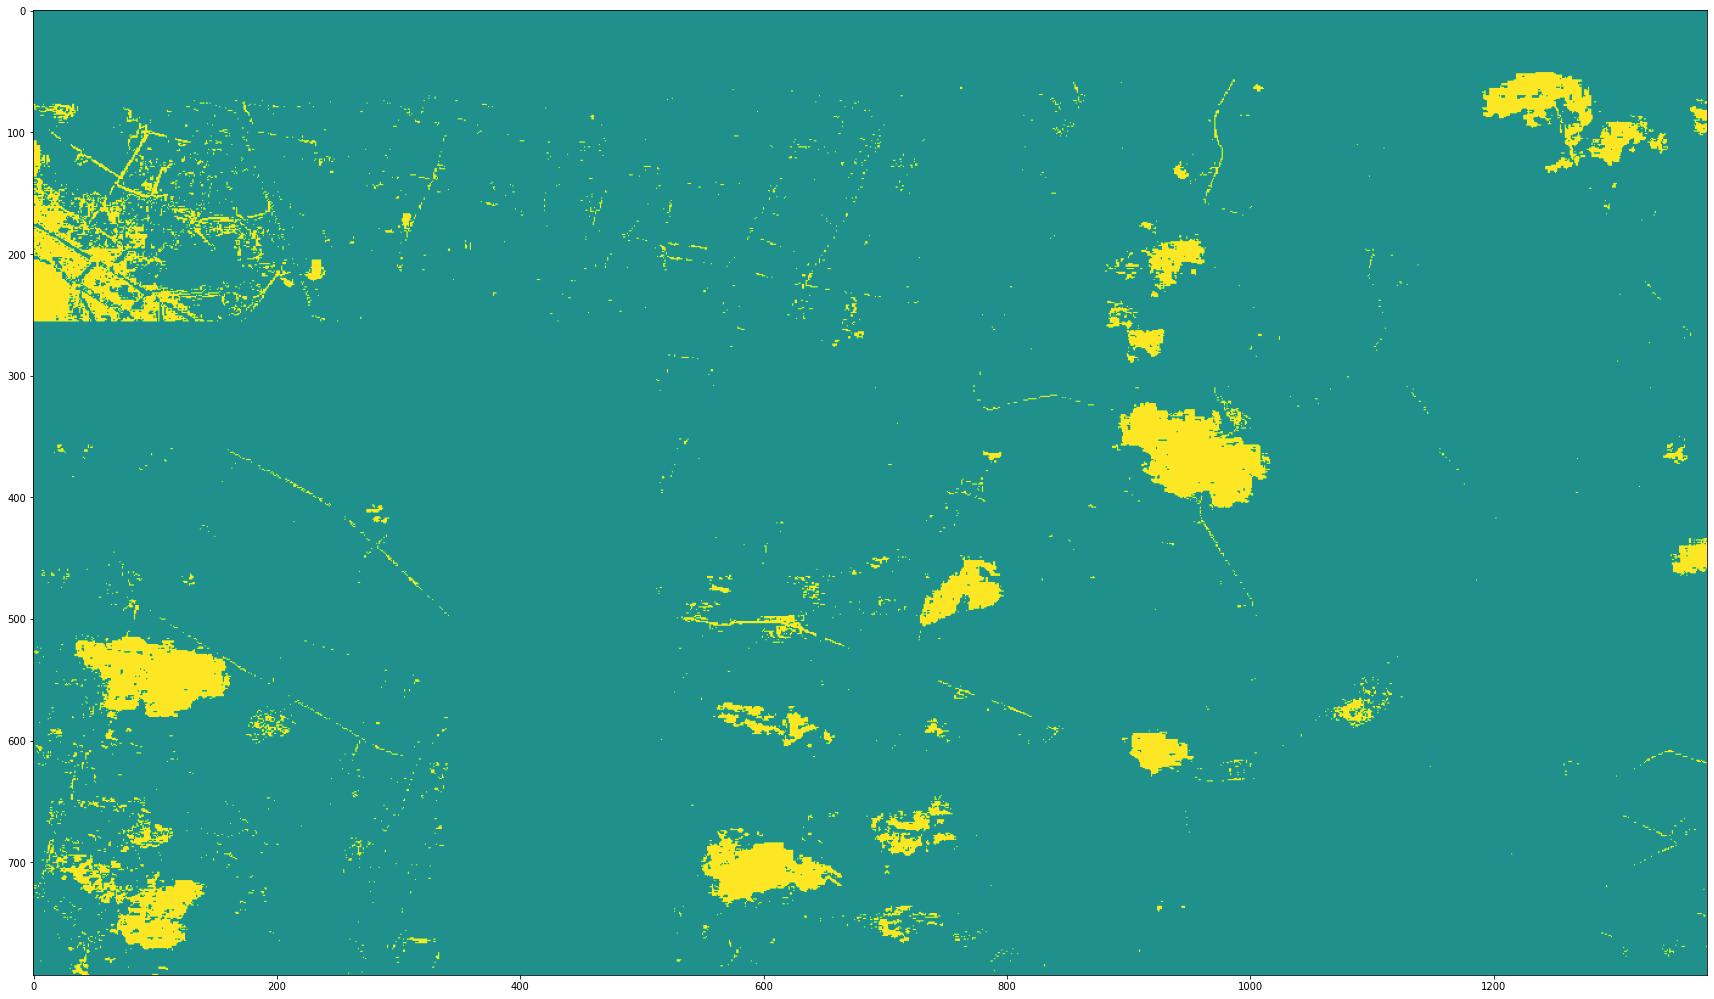

In [31]:

fig, ax = plt.subplots(figsize=(30,20))

rasterio_plot(gt_binary[cloud_channel], vmin=0, vmax=2)

plt.show()

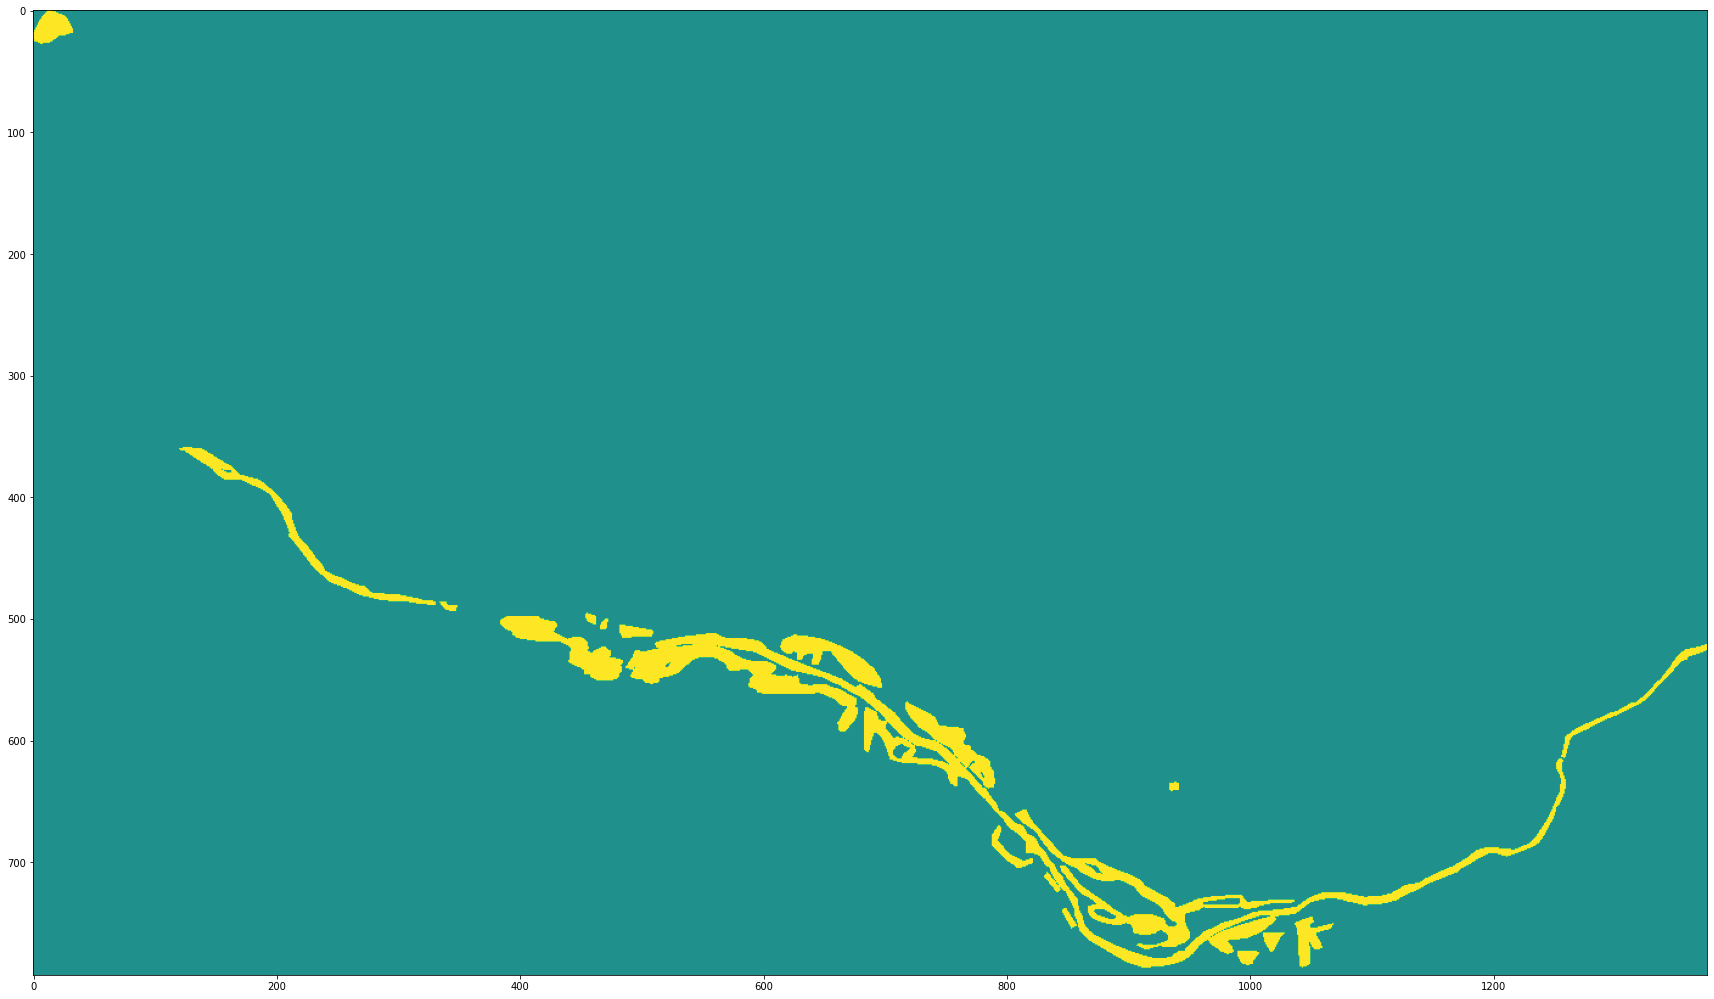

In [32]:

fig, ax = plt.subplots(figsize=(30,20))


rasterio_plot(gt_binary[water_channel], vmin=0, vmax=2)

plt.show()